In [4]:
import sys
from dotenv import load_dotenv
import os

load_dotenv()

sys.path.append(os.getenv("ROOT"))

In [5]:
import polars as pl
import numpy as np
from datetime import date
import silverfund.data_access_layer as dal
from silverfund.enums import Interval
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Load dataset
df = dal.load_crsp(interval=Interval.MONTHLY)

df

permno,permco,date,ncusip,ticker,shrcd,exchcd,siccd,prc,ret,retx,vol,shrout,cfacshr
i64,i64,date,str,str,i64,i64,i64,f64,f64,f64,f64,f64,f64
10000,7952,1986-01-31,"""68391610""","""OMFGA""",10,3,3990,-4.375,null,null,1771.0,3680.0,1.0
10000,7952,1986-02-28,"""68391610""","""OMFGA""",10,3,3990,-3.25,-0.257143,-0.257143,828.0,3680.0,1.0
10000,7952,1986-03-31,"""68391610""","""OMFGA""",10,3,3990,-4.4375,0.365385,0.365385,1078.0,3680.0,1.0
10000,7952,1986-04-30,"""68391610""","""OMFGA""",10,3,3990,-4.0,-0.098592,-0.098592,957.0,3793.0,1.0
10000,7952,1986-05-30,"""68391610""","""OMFGA""",10,3,3990,-3.10938,-0.222656,-0.222656,1074.0,3793.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
93436,53453,2024-07-31,"""88160R10""","""TSLA""",11,3,9999,232.07001,0.172781,0.172781,2.9287946e7,3.19464e6,1.0
93436,53453,2024-08-30,"""88160R10""","""TSLA""",11,3,9999,214.11,-0.077391,-0.077391,1.6108365e7,3.19464e6,1.0
93436,53453,2024-09-30,"""88160R10""","""TSLA""",11,3,9999,261.63,0.221942,0.221942,1.6042065e7,3.207e6,1.0


In [7]:
# Form momentum signal

# Log returns
df = df.with_columns(pl.col("ret").log1p().alias("logret"))

# Rolling sum from t-12 to t-2
df = df.with_columns(
    pl.col("logret").rolling_sum(window_size=11, min_periods=11).over("permno").alias("mom")
)

# Lag once, skip once
df = df.with_columns(pl.col("mom").shift(2).over("permno"))

df

permno,permco,date,ncusip,ticker,shrcd,exchcd,siccd,prc,ret,retx,vol,shrout,cfacshr,logret,mom
i64,i64,date,str,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64
10000,7952,1986-01-31,"""68391610""","""OMFGA""",10,3,3990,-4.375,null,null,1771.0,3680.0,1.0,null,null
10000,7952,1986-02-28,"""68391610""","""OMFGA""",10,3,3990,-3.25,-0.257143,-0.257143,828.0,3680.0,1.0,-0.297252,null
10000,7952,1986-03-31,"""68391610""","""OMFGA""",10,3,3990,-4.4375,0.365385,0.365385,1078.0,3680.0,1.0,0.311436,null
10000,7952,1986-04-30,"""68391610""","""OMFGA""",10,3,3990,-4.0,-0.098592,-0.098592,957.0,3793.0,1.0,-0.103797,null
10000,7952,1986-05-30,"""68391610""","""OMFGA""",10,3,3990,-3.10938,-0.222656,-0.222656,1074.0,3793.0,1.0,-0.251872,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93436,53453,2024-07-31,"""88160R10""","""TSLA""",11,3,9999,232.07001,0.172781,0.172781,2.9287946e7,3.19464e6,1.0,0.159378,-0.385232
93436,53453,2024-08-30,"""88160R10""","""TSLA""",11,3,9999,214.11,-0.077391,-0.077391,1.6108365e7,3.19464e6,1.0,-0.08055,-0.301196
93436,53453,2024-09-30,"""88160R10""","""TSLA""",11,3,9999,261.63,0.221942,0.221942,1.6042065e7,3.207e6,1.0,0.200441,-0.10623


In [8]:
# Filters

# Price greater than 5
df = df.with_columns(pl.col("prc").shift(1).over("permno").alias("prclag"))
df = df.filter(pl.col("prclag") > 5)

# Non-null momentum signal
df = df.drop_nulls(subset=["mom"])

df

permno,permco,date,ncusip,ticker,shrcd,exchcd,siccd,prc,ret,retx,vol,shrout,cfacshr,logret,mom,prclag
i64,i64,date,str,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10001,7953,1987-02-27,"""39040610""","""GFGC""",11,3,4920,6.25,-0.074074,-0.074074,365.0,991.0,3.0,-0.076961,0.196692,6.75
10001,7953,1987-03-31,"""39040610""","""GFGC""",11,3,4920,6.375,0.0368,0.02,216.0,991.0,3.0,0.036139,0.140122,6.25
10001,7953,1987-04-30,"""39040610""","""GFGC""",11,3,4920,-6.125,-0.039216,-0.039216,188.0,991.0,3.0,-0.040006,0.038273,6.375
10001,7953,1987-07-31,"""39040610""","""GFGC""",11,3,4920,6.0,0.021277,0.021277,215.0,991.0,3.0,0.021054,-0.026546,5.875
10001,7953,1987-08-31,"""39040610""","""GFGC""",11,3,4920,6.5,0.083333,0.083333,314.0,991.0,3.0,0.080042,0.03386,6.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93436,53453,2024-07-31,"""88160R10""","""TSLA""",11,3,9999,232.07001,0.172781,0.172781,2.9287946e7,3.19464e6,1.0,0.159378,-0.385232,197.88
93436,53453,2024-08-30,"""88160R10""","""TSLA""",11,3,9999,214.11,-0.077391,-0.077391,1.6108365e7,3.19464e6,1.0,-0.08055,-0.301196,232.07001
93436,53453,2024-09-30,"""88160R10""","""TSLA""",11,3,9999,261.63,0.221942,0.221942,1.6042065e7,3.207e6,1.0,0.200441,-0.10623,214.11


In [9]:
# Create portfolio bins

labels = [str(x) for x in range(10)]

df = df.with_columns(pl.col("mom").qcut(10, labels=labels).over("date").alias("bin"))

df

permno,permco,date,ncusip,ticker,shrcd,exchcd,siccd,prc,ret,retx,vol,shrout,cfacshr,logret,mom,prclag,bin
i64,i64,date,str,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,cat
10001,7953,1987-02-27,"""39040610""","""GFGC""",11,3,4920,6.25,-0.074074,-0.074074,365.0,991.0,3.0,-0.076961,0.196692,6.75,"""6"""
10001,7953,1987-03-31,"""39040610""","""GFGC""",11,3,4920,6.375,0.0368,0.02,216.0,991.0,3.0,0.036139,0.140122,6.25,"""5"""
10001,7953,1987-04-30,"""39040610""","""GFGC""",11,3,4920,-6.125,-0.039216,-0.039216,188.0,991.0,3.0,-0.040006,0.038273,6.375,"""3"""
10001,7953,1987-07-31,"""39040610""","""GFGC""",11,3,4920,6.0,0.021277,0.021277,215.0,991.0,3.0,0.021054,-0.026546,5.875,"""4"""
10001,7953,1987-08-31,"""39040610""","""GFGC""",11,3,4920,6.5,0.083333,0.083333,314.0,991.0,3.0,0.080042,0.03386,6.0,"""3"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93436,53453,2024-07-31,"""88160R10""","""TSLA""",11,3,9999,232.07001,0.172781,0.172781,2.9287946e7,3.19464e6,1.0,0.159378,-0.385232,197.88,"""0"""
93436,53453,2024-08-30,"""88160R10""","""TSLA""",11,3,9999,214.11,-0.077391,-0.077391,1.6108365e7,3.19464e6,1.0,-0.08055,-0.301196,232.07001,"""0"""
93436,53453,2024-09-30,"""88160R10""","""TSLA""",11,3,9999,261.63,0.221942,0.221942,1.6042065e7,3.207e6,1.0,0.200441,-0.10623,214.11,"""1"""


In [ ]:
# Create portfolio returns dataframe

# Aggregate (equal weight portfolios)
port = df.group_by(["date", "bin"]).agg(pl.col("ret").mean())

# Pivot
port = port.pivot(on="bin", index="date", values="ret")

# Reorder columns
port = port.select(["date"] + labels)

# Sort
port = port.sort(by="date")

port

date,0,1,2,3,4,5,6,7,8,9
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1927-01-31,-0.050276,0.031919,0.059319,0.007087,0.018295,0.006941,0.002777,0.014934,-0.003197,0.020425
1927-02-28,0.066904,0.07758,0.0945242,0.069478,0.0489,0.067351,0.055496,0.048553,0.056516,0.05689
1927-03-31,-0.025914,-0.021284,-0.03428,-0.035479,-0.014467,-0.002582,0.004282,-0.006684,0.009371,0.005788
1927-04-30,0.004056,-0.03045,-0.002476,-0.012808,0.000279,-0.009863,0.002191,-0.004359,0.005621,0.056733
1927-05-31,0.007943,0.055033,0.048724,0.049507,0.072707,0.05452,0.070398,0.072703,0.082268,0.093484
…,…,…,…,…,…,…,…,…,…,…
2024-07-31,0.063492,0.065462,0.050963,0.033183,0.038694,0.044885,0.046226,0.042374,0.058832,0.059815
2024-08-30,-0.051108,-0.009573,0.001335,0.009518,0.013899,0.01186,0.014082,0.01312,0.012772,0.002565
2024-09-30,0.020841,0.020067,0.014254,0.011303,0.018988,0.019704,0.018997,0.016919,0.019107,0.015117


In [ ]:
# Create spread portfolio

port = port.with_columns((pl.col("9") - pl.col("0")).alias("spread"))

port

date,0,1,2,3,4,5,6,7,8,9,spread
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1927-01-31,-0.050276,0.031919,0.059319,0.007087,0.018295,0.006941,0.002777,0.014934,-0.003197,0.020425,0.070701
1927-02-28,0.066904,0.07758,0.0945242,0.069478,0.0489,0.067351,0.055496,0.048553,0.056516,0.05689,-0.010013
1927-03-31,-0.025914,-0.021284,-0.03428,-0.035479,-0.014467,-0.002582,0.004282,-0.006684,0.009371,0.005788,0.031703
1927-04-30,0.004056,-0.03045,-0.002476,-0.012808,0.000279,-0.009863,0.002191,-0.004359,0.005621,0.056733,0.052677
1927-05-31,0.007943,0.055033,0.048724,0.049507,0.072707,0.05452,0.070398,0.072703,0.082268,0.093484,0.085541
…,…,…,…,…,…,…,…,…,…,…,…
2024-07-31,0.063492,0.065462,0.050963,0.033183,0.038694,0.044885,0.046226,0.042374,0.058832,0.059815,-0.003678
2024-08-30,-0.051108,-0.009573,0.001335,0.009518,0.013899,0.01186,0.014082,0.01312,0.012772,0.002565,0.053673
2024-09-30,0.020841,0.020067,0.014254,0.011303,0.018988,0.019704,0.018997,0.016919,0.019107,0.015117,-0.005724


In [ ]:
# Unpivot dataframe
port = port.unpivot(index="date", variable_name="bin", value_name="ret")

# Sort
port = port.sort(by=["date", "bin"])

port

date,bin,ret
date,str,f64
1927-01-31,"""0""",-0.050276
1927-01-31,"""1""",0.031919
1927-01-31,"""2""",0.059319
1927-01-31,"""3""",0.007087
1927-01-31,"""4""",0.018295
…,…,…
2024-11-29,"""6""",0.063629
2024-11-29,"""7""",0.070207
2024-11-29,"""8""",0.090031


In [ ]:
# Calculate mean, std, sharpe, and tstat of each portfolio

# Mean, std, and count
result = port.group_by("bin").agg(
    [
        pl.col("ret").mean().cast(pl.Float64).alias("mean"),
        pl.col("ret").std().cast(pl.Float64).alias("std"),
        pl.col("ret").count().cast(pl.Float64).alias("count"),
    ]
)

# Sharpe
result = result.with_columns(
    ((pl.col("mean") * 12) / (pl.col("std") * np.sqrt(12)))
    .cast(pl.Float64)
    .alias("annualized_sharpe")
)

# Tstat
result = result.with_columns(
    (pl.col("mean") / (pl.col("std") / pl.col("count").sqrt())).cast(pl.Float64).alias("tstat")
)

# Sort
result = result.sort(by="bin")

# Transpose
result = result.transpose(include_header=True, column_names="bin", header_name="statistic")

print("Monthly results")
result

Monthly results


statistic,0,1,2,3,4,5,6,7,8,9,spread
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""mean""",0.002567,0.00817,0.009366,0.009605,0.010561,0.011539,0.012466,0.01319,0.014981,0.017054,0.014486
"""std""",0.091979,0.07651,0.068471,0.063467,0.059956,0.059002,0.057584,0.059188,0.061684,0.072946,0.063501
"""count""",1175.0,1175.0,1175.0,1175.0,1175.0,1175.0,1175.0,1175.0,1175.0,1175.0,1175.0
"""annualized_sharpe""",0.096696,0.369906,0.473836,0.524242,0.610217,0.677499,0.749932,0.771968,0.841318,0.809852,0.790242
"""tstat""",0.956834,3.660323,4.688747,5.187528,6.038272,6.704045,7.420794,7.638848,8.325077,8.013712,7.819667


In [ ]:
# Create backtest plot

# Log returns
port = port.with_columns(pl.col("ret").log1p().over("bin").alias("logret"))

# Cummulative sum log returns
port = port.with_columns(pl.col("logret").cum_sum().over("bin").alias("cumret") * 100)

port

date,bin,ret,logret,cumret
date,str,f64,f64,f64
1927-01-31,"""0""",-0.050276,-0.051584,-5.158402
1927-01-31,"""1""",0.031919,0.03142,3.142026
1927-01-31,"""2""",0.059319,0.057626,5.762593
1927-01-31,"""3""",0.007087,0.007063,0.70625
1927-01-31,"""4""",0.018295,0.018129,1.812927
…,…,…,…,…
2024-11-29,"""6""",0.063629,0.061686,1263.587951
2024-11-29,"""7""",0.070207,0.067852,1335.679749
2024-11-29,"""8""",0.090031,0.086206,1524.041208


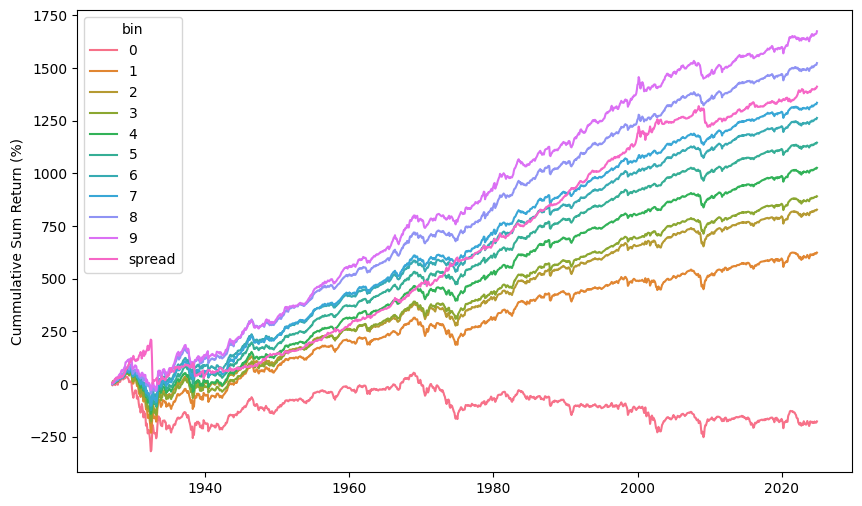

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(port, x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

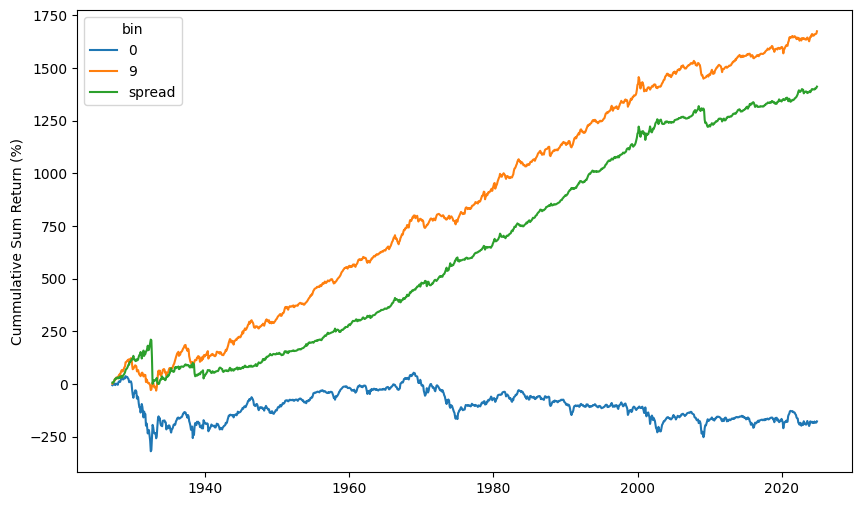

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    port.filter(pl.col("bin").is_in(["0", "9", "spread"])), x="date", y="cumret", hue="bin"
)
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

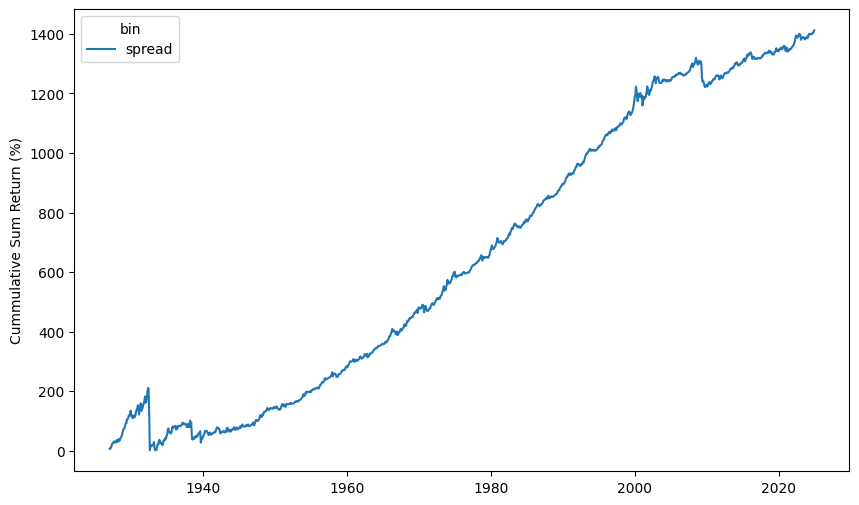

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(port.filter(pl.col("bin") == "spread"), x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

In [ ]:
min_date = port["date"].min().strftime("%Y-%m-%d")
max_date = port["date"].max().strftime("%Y-%m-%d")

print(f"From {min_date} to {max_date}")

From 1927-01-31 to 2024-11-29


In [ ]:
spread = port.filter(pl.col("bin") == "spread").sort("date")["ret"]

portfolio_er = spread.mean()
portfolio_vol = np.sqrt(spread.std())

portfolio_sharpe = (portfolio_er / portfolio_vol) * np.sqrt(252)

print(f"Portfolio sharpe: {portfolio_sharpe:.4f}")

Portfolio sharpe: 0.9126
